# Overview-Notebook for WSI datasets 

In [1]:
# imports
import json
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import yaml
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from typing import Union
from openslide import open_slide

from typing import Callable, Dict, List, Optional, Sequence, Tuple, Union


In [ ]:
import sys
sys.path.append('..')

from src.deephist.data_provider import DataProvider

data_provider = DataProvider(test_data='/homes/oester/repositories/prae/data/segmentation/preprocessed/HEEL_seg')
wsis = data_provider.test_wsi_dataset.wsis
wsis[0].get_pred_dict()

ModuleNotFoundError: No module named 'torch'

In [6]:
# set important paths

# CONFIG_YAML = Path to configuration yaml, file is created by running pre-histo procedure for extracting patches
CONFIG_YAML = '/homes/oester/repositories/prae/data/segmentation/preprocessed/HEEL_seg/prehisto-config.yml'
with open(CONFIG_YAML, 'r') as f:
    try:
        config_yaml = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

wsi_path = config_yaml['wsi_path']
db_path = config_yaml['db_path']
plot_path = config_yaml['plot_path']
with open(config_yaml['label_map_file']) as f:
  label_map = json.load(f)


# Output Structure

The pre-histo output folder has (and needs to have) the following structure:
* Output 
  * WSI1
    * -1: Patches without a label (with no annotation)
    * Annotation1: Class-Number assignment can be found in label_map.json
    * Annotation2:
    * ...
    * WSI1_metadata.yaml: Metadata of WSI1
  * WSI1_mask.png: Otsu-Thresholding mask WSI1
  * WSI2
    * -1: Patches without a label (with no annotation)
    * Annotation1: Class-Number assignment can be found in label_map.json
    * Annotation2:
    * ...
    * WSI2_metadata.yaml: Metadata of WSI2
  * WSI2_mask.png: Otsu-Tresholding mask WSI2
  * ...
  * plot: Class plots for every WSI


In [7]:
# Key facts for checking 
wsi_list = [folder for folder in os.listdir(db_path) if os.path.isdir(os.path.join(db_path, folder))]
try: 
    wsi_list.remove(plot_path)
except ValueError:
    print("No Plot folder in path")
print(
    f"{'Number of processed WSI:':<30}{len(wsi_list):>5}",
    f"\n{'Number of different classes:':<30}{len(label_map):>5}",
)


Number of processed WSI:        138 
Number of different classes:     18


## WSI Report

In [20]:
# plot function
class WSI():
    def __init__(self, filename: str, db_path: str, plot_path: str, wsi_path: str, label_map: dict, config: dict) -> None:
        """Initialize WSI object

        Args:
            filename (str): Path to WSI file, e.g. /path/to/wsi/wsi.svs
            db_path (str): Path to pre-histo output folder
            plot_path (str): Path to overview plots, relative path to db_path
            wsi_path (str): Path to WSI folder with the WSI, e.g. /path/to/wsi/
            label_map (dict): label_map as dictionary, keys: class_name, values: number
            config (dict): config file which was used for the pre-histo package
        """
        self.filename = os.path.basename(filename)
        self.output = os.path.join(db_path, self.filename)
        self.db_path = db_path
        self.plot_path = plot_path
        self.wsi_path = wsi_path
        self.label_map = label_map
        self.config = config
        self.mask_file = os.path.join(db_path, os.path.splitext(self.filename)[0] + '_mask.png', )
        with open(os.path.join(self.output, self.filename + '_metadata.yaml') , 'r') as f:
            try:
                self.metadata = yaml.safe_load(f)
            except yaml.YAMLError as exc:
                print(exc)

    def get_extracted_classes(self) -> Tuple[int, dict]:
        """Calculate per class number of patches

        Returns:
            tuple[int, list]: returns number of classes inside the wsi and a dict with total number of patches per class as values and classes as keys
        """
        folder_list = [f for f in os.listdir(self.output) if os.path.isdir(os.path.join(self.output, f))]
        self.patch_overview = {}
        # get number of patches per class
        for patch_class in folder_list:
            patch_path = os.path.join(self.output, patch_class)
            self.patch_overview[patch_class] = len([f for f in os.listdir(patch_path) if os.path.isfile(os.path.join(patch_path, f))])
         
        return len(folder_list), self.patch_overview
    
    def print_overview(self):
        """Print overview of WSI stats
        """
        self.get_extracted_classes()
        #print(f"Shut the door{'s' if abs(num_doors) != 1 else ''}.")
        print(
            f"{self.filename}",
            f"\n{len(self.filename)*'-' if len(self.filename) > 45 else 45*'-'}",
            #f"\n{'Patch Magnification:':<35}{self.metadata['magnification']:>10}",
            f"\n{'Number Columns:':<35}{self.metadata['org_n_tiles_col']:>10}",
            f"\n{'Number Rows:':<35}{self.metadata['org_n_tiles_row']:>10}",
            f"\n{'Total number patches:':<35}{self.metadata['org_n_tiles_row']*self.metadata['org_n_tiles_col']:>10}",
            f"\n{'Classes:':<35}{len(self.patch_overview):>10}"
        )
        for patch_class in self.patch_overview:
            print(
                f"{'Elements class ' + patch_class + ':':<35}{self.patch_overview[patch_class]:>10}",
            )
        print(
            f"{'Total number patches extracted:':<35}{sum(self.patch_overview.values()):>10}",
            f"\n{'Total number background patches:':<35}{self.metadata['org_n_tiles_row']*self.metadata['org_n_tiles_col'] - sum(self.patch_overview.values()):>10}"
        )

    def plot_overview(self, save_folder: str = None, textstring: str = None):
        """Create overview image for wsi

        Args:
            save_folder (str, optional): Path where to store the overview image. Defaults to None.
        """
        
        # load images from pre-histo
        plot_path_full = os.path.join(self.db_path, self.plot_path)
        plot_list = [f for f in os.listdir(plot_path_full) if os.path.isfile(os.path.join(plot_path_full, f))]
        plot_list = [f for f in plot_list if f[:len(os.path.splitext(self.filename)[0])] == str(os.path.splitext(self.filename)[0])]
        plot_list.remove(os.path.splitext(self.filename)[0] + '.png')

        # import class mask images
        class_images = [plt.imread(os.path.join(plot_path_full, f)) for f in plot_list]
        num_classes, class_overview = self.get_extracted_classes()
        
        # generate thumbnail
        x_size= class_images[0].shape[0]
        y_size= class_images[0].shape[1]
        openslide_wsi = open_slide(os.path.join(self.wsi_path, self.filename))
        thumbnail = openslide_wsi.get_thumbnail((x_size, y_size))

        # random sample 10 images from every class
        folder_list = [f for f in os.listdir(self.output) if os.path.isdir(os.path.join(self.output, f))]
        patches = []
        patch_size = self.config['patch_size']
        for element, patch_class in enumerate(folder_list):
            patches.append(np.zeros((2*patch_size, 5*patch_size, 3)))
            patch_path = os.path.join(self.output, patch_class)
            patch_filelist = [os.path.join(patch_path, f) for f in os.listdir(patch_path) if os.path.isfile(os.path.join(patch_path, f))]
            patch_filelist = np.random.permutation(patch_filelist)
            index = 0
            try:
                for i in range(5):
                    for j in range(2):
                        patches[element][patch_size*j:patch_size*(j+1), patch_size*i:patch_size*(i+1), :]=plt.imread(patch_filelist[index])
                        index += 1
            except IndexError:
                print('Not enough patches to sample from')

        # create class overview
        class_patches = np.array(list(class_overview.values())).T
        inverse_label_map = {str(v): k for k, v in self.label_map.items()}
        class_number_list = list(class_overview.keys())
        legend_list = [inverse_label_map[key] for key in class_number_list]

        # plot results
        # Create grid
        fig = plt.figure(figsize=(16,9))
        fig.suptitle(f'Evaluation: {self.filename}')
        ax = []
        rows = max(num_classes, 2)
        if num_classes == 1:
            ax.append(plt.subplot2grid((rows, 2), (0, 0)))
            ax.append(plt.subplot2grid((rows, 2), (1, 0), rowspan=rows-1))
            for row in range(rows):
                ax.append(plt.subplot2grid((rows, 2), (row, 1)))
        else:
            ax.append(plt.subplot2grid((rows, 3), (0, 0)))
            ax.append(plt.subplot2grid((rows, 3), (1, 0), rowspan=rows-1))
            for row in range(rows):
                ax.append(plt.subplot2grid((rows, 3), (row, 1))) 
            for row in range(rows):
                ax.append(plt.subplot2grid((rows, 3), (row, 2)))
        
        # show thumbnail
        ax[0].imshow(thumbnail)
        ax[0].set_xlabel('width in px')
        ax[0].set_ylabel('height in px')
        ax[0].set_title('Thumbnail of WSI')
        
        # show patch evaluation
        colormap = iter(matplotlib.cm.get_cmap('Paired').colors)
        bottom = np.zeros(num_classes)
        ax[1].yaxis.grid(zorder=0)
        bar_stacked = []
        for row in range(num_classes):
            c = next(colormap)
            bar_stacked.append(ax[1].bar('Patches', class_patches[row], color=c, bottom=bottom, zorder=3))
            bottom += np.array(class_patches[row])
        for row, element in enumerate(bar_stacked):
            ax[1].bar_label(element, label_type='center')
        ax[1].set_ylabel('Absolute Values')
        ax[1].set_title('Distribution of patches (absolute)')
        ax[1].set_xlim((-1, 5))
        ax[1].legend(legend_list, loc='upper right')
        if textstring is not None:
            ax[1].text(
                0.7, 
                0.15, 
                textstring, 
                transform=ax[1].transAxes, 
                bbox=dict(facecolor='lightblue', alpha=0.5), 
                horizontalalignment='center',
                verticalalignment='center'
            )

        # Plot class masks
        for row in range(num_classes):
            ax[2+row].imshow(class_images[row])
            ax[2+row].set_xlabel('width in px')
            ax[2+row].set_ylabel('height in px')
            ax[2+row].set_title(f'{inverse_label_map[class_number_list[row]]}')
        
        # Plot random images per class
        for row in range(num_classes):
            ax[2+num_classes+row].imshow(patches[row])
            ax[2+num_classes+row].set_xlabel('Example images')
            ax[2+num_classes+row].set_xticks(patch_size*np.arange(6))
            ax[2+num_classes+row].set_xticklabels(np.arange(6))
            ax[2+num_classes+row].set_yticks(patch_size*np.arange(3))
            ax[2+num_classes+row].set_yticklabels(np.arange(3))
            ax[2+num_classes+row].set_title(f'{inverse_label_map[class_number_list[row]]}')
            ax[2+num_classes+row].grid(color='black')
        plt.tight_layout()

        # saving
        if save_folder is not None:
            plt.savefig(os.path.join(save_folder, os.path.splitext(self.filename)[0] + '_review.png'), facecolor='white', dpi=200)
        return fig



### Create Overview plot for every WSI 

In [9]:
# Set: Path for saving the generated output plots  
overview_save_path = '/homes/oester/repositories/prae/data/exploration_output'
filenames = [f for f in os.listdir(db_path) if os.path.isdir(os.path.join(db_path, f))]

# Uncomment code below for execution. The code is commented out to prevent unintentional execution with a long runtime. 

# for filename in filenames:
#     wsi = WSI(
#         filename=filename,
#         db_path=db_path,
#         plot_path=plot_path,
#         wsi_path=wsi_path,
#         label_map=label_map,
#         config=config_yaml
#     )
#     textstring = 'Class object and object_with_marker are not mutually exclusive!'
#     figure = wsi.plot_overview(save_folder=overview_save_path, textstring=textstring)
#     plt.close(figure)

#### Overview for one specific WSI directly in the notebook:

RCC-TA-049.001~C.svs 
--------------------------------------------- 
Number Columns:                           118 
Number Rows:                              156 
Total number patches:                   18408 
Classes:                                    8
Elements class 17:                          3
Elements class 9:                        3314
Elements class 3:                         149
Elements class -1:                        143
Elements class 16:                         52
Elements class 5:                        1388
Elements class 12:                        909
Elements class 8:                         630
Total number patches extracted:          6588 
Total number background patches:        11820


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

Not enough patches to sample from


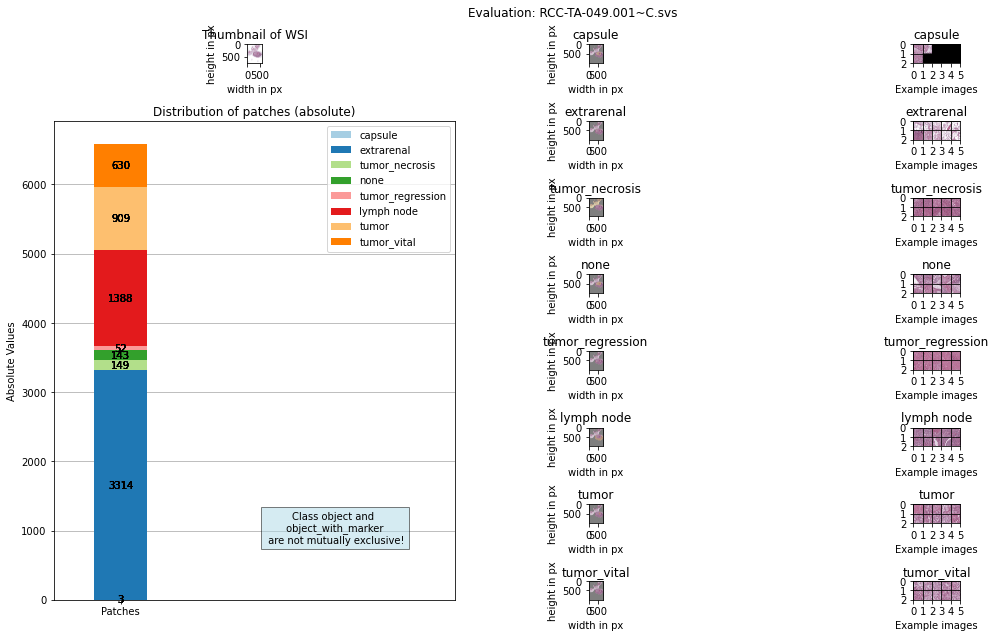

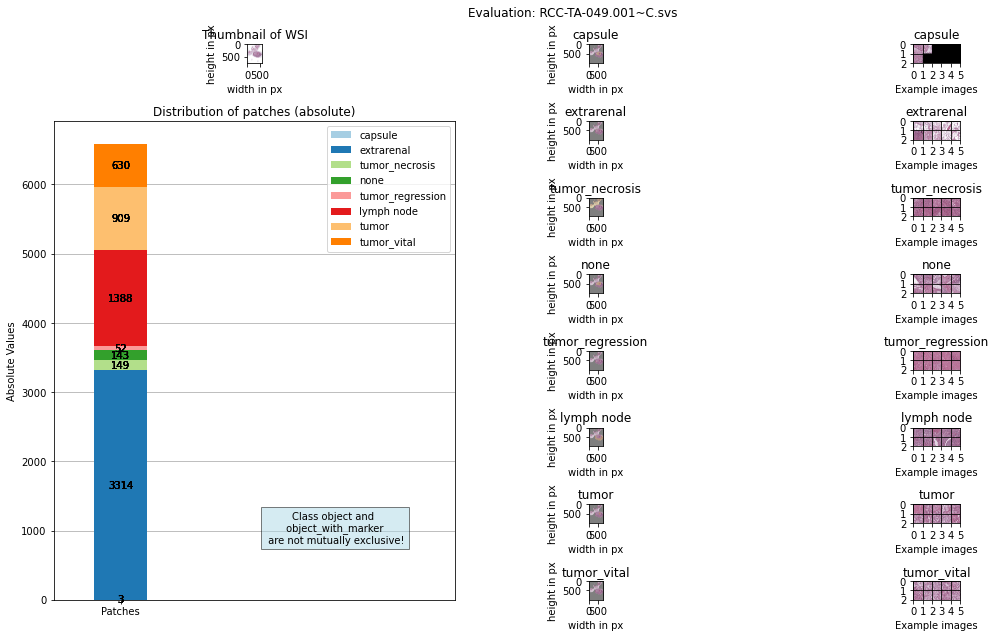

In [10]:
filename = '/projects/praediknika/data/from_mhh/RCCs_HE-El_svs/RCC-TA-049.001~C.svs'
test_wsi = WSI(
    filename=filename,
    db_path=db_path,
    plot_path=plot_path,
    wsi_path=wsi_path,
    label_map=label_map,
    config=config_yaml
)

textstring = 'Class object and \n object_with_marker \n are not mutually exclusive!'

#num_classes, classes = test_wsi.get_extracted_classes()
test_wsi.print_overview()
test_wsi.plot_overview(textstring=textstring)


### Generate distribution overviews for list of WSIs

In [21]:
def plot_distribution(
    wsi: Union[WSI, List[WSI]], 
    label_map: dict,
    ax: matplotlib.axes._subplots,
    normalized: bool=False,
    row_label: bool=True, 
    **kwargs) -> matplotlib.axes._subplots:
    """Plot distribution of patches for a list of WSI

    Args:
        wsi (Union[WSI, list[WSI]]): WSI object
        label_map (dict): label_map as dictionary, keys: class_name, values: number
        ax (matplotlib.axes._subplots): matplotlib axes object
        normalized (bool, optional): If data should be normalized to be in the range (0, 1). Defaults to False.

    Returns:
        matplotlib.axes._subplots: matplotlib axes object
    """
    # TODO: Mutually exclusive vs non mutually exclusive
    # get data and save in dataframe    
    data_df = pd.DataFrame()
    if type(wsi) is not list:
        wsi = [wsi]
    for image in wsi:
            num_classes, classes = image.get_extracted_classes()
            data_df = data_df.append(classes, ignore_index=True)
    # replace nan values with 0 and convert to numpy array
    data = data_df.fillna(0).to_numpy().T
    if normalized:
        factor = np.sum(data, axis=0)
        data = data/factor
    
    # Plotting 
    if 'label' not in kwargs:
        label = [image.filename for image in wsi]
    else:
        label = kwargs['label']
    colormap = iter(matplotlib.cm.get_cmap('Paired').colors)
    bottom = np.zeros(len(label))
    ax.yaxis.grid(zorder=0)
    bar_stacked = []
    for row in range(data.shape[0]):
        c = next(colormap)
        bar_stacked.append(ax.bar(label, data[row,:] , width = 0.7, color=c, bottom=bottom, zorder=3))
        bottom += np.array(data[row,:])
    if row_label:
        for row, element in enumerate(bar_stacked):
            # create bar labels, replace 0 with empty label
            row_label = data[row,:].tolist()
            if normalized:
                row_label = ['' if element==0 else f"{element:.3f}" for element in row_label]
            else: 
                row_label = ['' if element==0 else str(int(element)) for element in row_label]
            ax.bar_label(element, labels=row_label, label_type='center')

    ax.set_ylabel('Relative value') if normalized else ax.set_ylabel('Absolute Values')
    ax.set_xlabel('WSI')
    ax.set_title('Distribution of patches (normalized)') if normalized else ax.set_title('Distribution of patches')
    ax.legend(label_map.keys())

    return ax


#### Relative overview for a list of WSI

StopIteration: 

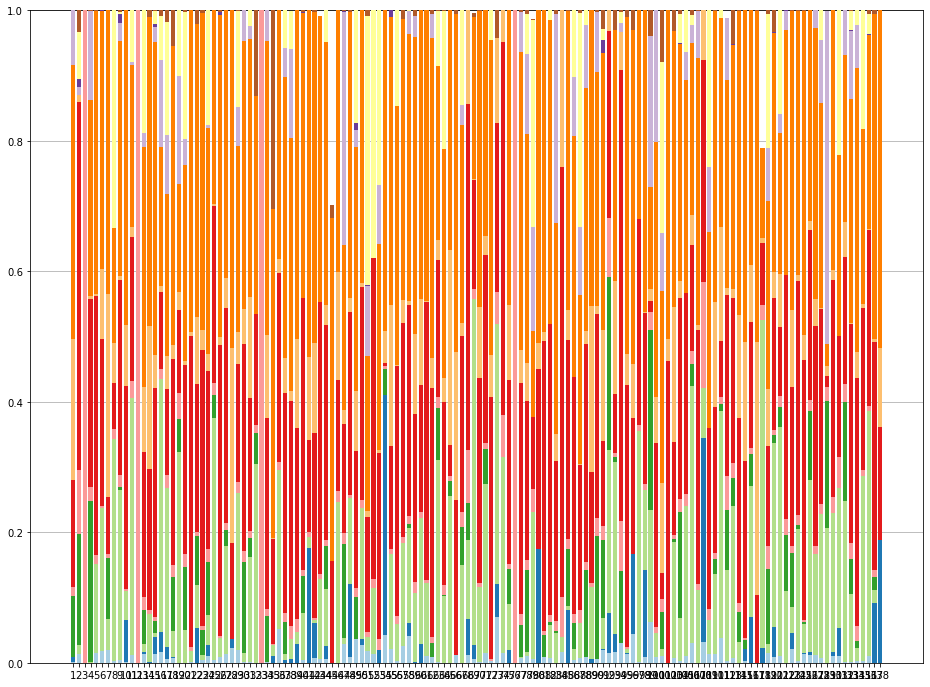

In [23]:
# Create a list with paths
# filelist = [
#     '/Users/fhoerst/Masterarbeit/Datensätze/memori/Testdaten-Preprocessing/WSI/ID_0102_B1_L5_E2021_15_BUKII2009.svs',
#     '/Users/fhoerst/Masterarbeit/Datensätze/memori/Testdaten-Preprocessing/WSI/ID_0102_B1_L6_E2021_15_BUKII2009.svs',
#     '/Users/fhoerst/Masterarbeit/Datensätze/memori/Testdaten-Preprocessing/WSI/ID_0115_B1_L4_E2020_207_BULTW2103.svs',
#     '/Users/fhoerst/Masterarbeit/Datensätze/memori/Testdaten-Preprocessing/WSI/ID_0115_B1_L4_E2021_15_BUUNN2123.svs',
#     '/Users/fhoerst/Masterarbeit/Datensätze/memori/Testdaten-Preprocessing/WSI/ID_0121_B1_L3_E2020_207_BUUXL2119.svs',
#     '/Users/fhoerst/Masterarbeit/Datensätze/memori/Testdaten-Preprocessing/WSI/ID_0135_B1_L1_E2021_15_BUIHJ2175.svs',
#     '/Users/fhoerst/Masterarbeit/Datensätze/memori/Testdaten-Preprocessing/WSI/ID_2102_B1_L6_E2020_207_BULAS2102.svs'
# ]
# label = ['1', '2', '3', '4', '5', '6', '7']

# alternative for all (or subset) wsi inside a folder:
filelist = [f for f in os.listdir(db_path) if os.path.isdir(os.path.join(db_path, f)) and Path(f).name != 'plot'] 
#filelist = filelist[:100]
label = [str(element) for element in np.arange(1, len(filelist)+1)]

image_list = [WSI(filename=f, db_path=db_path, plot_path=plot_path, wsi_path=wsi_path, label_map=label_map, config=config_yaml) for f in filelist]
fig, ax = plt.subplots(1, 1, figsize=(16,12))
ax = plot_distribution(
    wsi=image_list, 
    label_map=label_map, 
    ax=ax, 
    normalized=True,
    row_label=False,
    label=label,
)

#### Absolute overview for a list of WSI

StopIteration: 

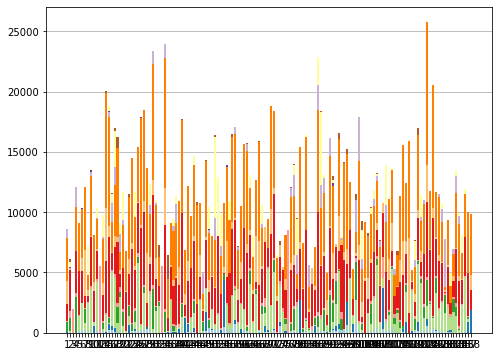

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax = plot_distribution(
    wsi=image_list, 
    label_map=label_map, 
    ax=ax,
    label=label
)

# Dataset report

In [ ]:
def get_dataset_report(
        wsi: Union[WSI, List[WSI]], 
        label_map: dict, 
        fig: matplotlib.figure,
        ax#: List[matplotlib.axes._subplots]
    ) -> matplotlib.axes._subplots:
    """Generate a report about the entire dataset

    Args:
    Args:
        wsi (Union[WSI, list[WSI]]): WSI object
        label_map (dict): label_map as dictionary, keys: class_name, values: number
        fig (matplotlib.figure): Matplotlib figure object
        ax (matplotlib.axes._subplots): matplotlib axes object

    Returns:
        matplotlib.axes._subplots: [description]
    """
    # get data and save in dataframe    
    data_df = pd.DataFrame()
    if type(wsi) is not list:
        wsi = [wsi]
    for image in wsi:
            num_classes, classes = image.get_extracted_classes()
            data_df = data_df.append(classes, ignore_index=True)

    # replace nan values with 0 and convert to numpy array
    data = data_df.fillna(0)
    mean_patches_absolute = data.mean()
    var_patches_absolute = data.std()
    
    # normalized data
    data_normalized = data_df.fillna(0).to_numpy().T
    data_normalized = (1/np.sum(data_normalized, axis=0)*data.transpose()).transpose()
    mean_patches_normalized = data_normalized.mean()
    var_patches_normalized = data_normalized.std()

    # create plots
    fig.suptitle('Distribution of patches per class')
    colormap = iter(matplotlib.cm.get_cmap('Paired').colors)
    c = next(colormap)

    ax[0].yaxis.grid(zorder=0)
    ax[0].bar(np.arange(len(mean_patches_absolute)),  mean_patches_absolute, yerr=var_patches_absolute, width = 0.5, color=c, zorder=3)
    ax[0].set_xticks(np.arange(len(mean_patches_absolute)))
    ax[0].set_xticklabels(label_map.keys())
    ax[0].set_ylabel('Mean and variance')
    ax[0].set_title('Absolute')
    ax[0].legend(['Mean', 'Variance'])

    ax[1].yaxis.grid(zorder=0)
    ax[1].bar(np.arange(len(mean_patches_normalized)),  mean_patches_normalized, yerr=var_patches_normalized, width = 0.5, color=c, zorder=3)
    ax[1].set_xticks(np.arange(len(mean_patches_normalized)))
    ax[1].set_xticklabels(label_map.keys())
    ax[1].set_ylabel('Mean and variance')
    ax[1].set_title('Normalized')
    ax[1].legend(['Mean', 'Variance'])

    # print data report
    print(
            f"Dataset overview",
            f"\n{60*'-'}",
            f"\n{'Total number patches:':<50}{int(np.sum(np.sum(data.to_numpy()))):>10}",
        )
    for i, patch_class in enumerate(label_map.keys()):
            print(
                f"{'Total number ' + patch_class + ' patches :':<50}{int(data.sum()[i]):>10}",
            )
    return ax 


In [ ]:
# Create a WSI object for every WSI file inside the WSI path
filelist = [f for f in os.listdir(wsi_path) if os.path.isfile(os.path.join(wsi_path, f))]
image_list = [WSI(filename=f, db_path=db_path, plot_path=plot_path, wsi_path=wsi_path, label_map=label_map, config=config_yaml) for f in filelist]
fig, ax = plt.subplots(1, 2, figsize=(8,6))

ax = get_dataset_report(wsi=image_list, label_map=label_map, fig=fig, ax=ax)

FileNotFoundError: [Errno 2] No such file or directory: '/homes/oester/repositories/prae/data/segmentation/preprocessed/HEEL_seg/RCC-TA-185.001~B/RCC-TA-185.001~B_metadata.yaml'

In [ ]:
# TODO: validity check number of patches per class